✅ Model and preprocessors loaded successfully!

🆕 New customer data loaded:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,919-TMRGD,Female,0,No,Yes,100,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,79.35,79.35



✅ Preprocessing complete:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,0,1,2.753404,1,0,1,0,0,0,0,2,0,0,1,2,0.483708,-0.972355



🎯 Predicted Result: No Churn


PermutationExplainer explainer: 2it [00:12, 12.43s/it]               


🔥 Top Features Influencing Prediction:


,feature,shap_value
4,tenure,-0.264167
17,MonthlyCharges,0.021667
18,TotalCharges,-0.015833


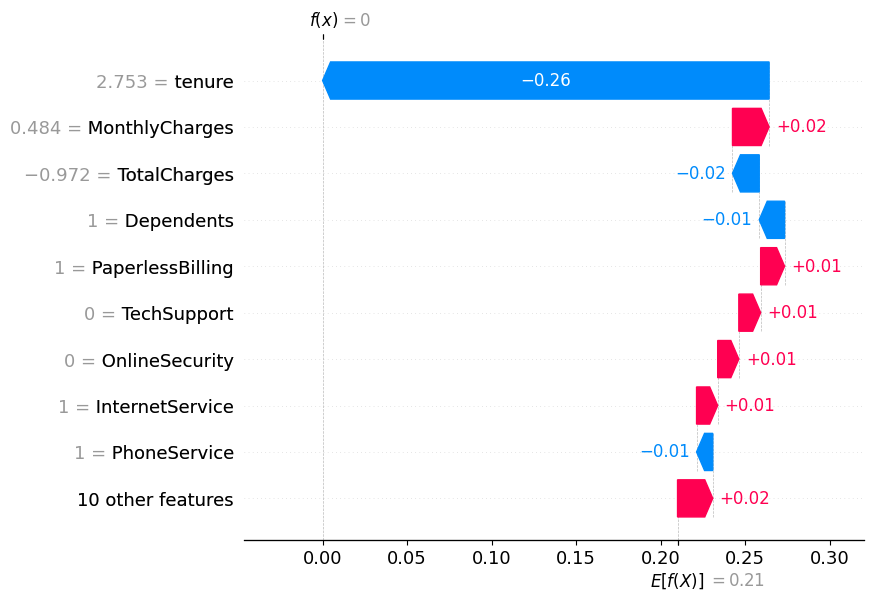

In [7]:
# 🧠 Predict_Churn.ipynb
# Proper SHAP + prediction for churn, using pipeline

import pandas as pd
import pickle
import shap

# -----------------------------
# 1️⃣ Load model and preprocessors
# -----------------------------
with open("best_model.pkl", "rb") as f:
    model = pickle.load(f)

with open("preprocessors.pkl", "rb") as f:
    preprocessors = pickle.load(f)
    
with open("best_cph_model.pkl", "rb") as f:
    saved = pickle.load(f)

label_encoders = preprocessors["label_encoders"]
scaler = preprocessors["scaler"]
categorical_cols = preprocessors["categorical_cols"]
numerical_cols_for_scaling = preprocessors["numerical_cols_for_scaling"]

print("✅ Model and preprocessors loaded successfully!")

# -----------------------------
# 2️⃣ New customer data
# -----------------------------
new_data = pd.DataFrame([{
    "customerID": "919-TMRGD",
    "gender": "Female",
    "SeniorCitizen": 0,
    "Partner": "No",
    "Dependents": "Yes",
    "tenure": 100,
    "PhoneService": "Yes",
    "MultipleLines": "No",
    "InternetService": "Fiber optic",
    "OnlineSecurity": "No",
    "OnlineBackup": "No",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "Yes",
    "StreamingMovies": "No",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": 79.35,
    "TotalCharges": 79.35
}])




print("\n🆕 New customer data loaded:")
display(new_data)

# -----------------------------
# 3️⃣ Preprocess new data (same as training)
# -----------------------------
processed_data = new_data.copy()

for col in categorical_cols:
    if col in processed_data.columns:
        le = label_encoders[col]
        processed_data[col] = processed_data[col].apply(lambda x: x if x in le.classes_ else le.classes_[0])
        processed_data[col] = le.transform(processed_data[col])

processed_data[numerical_cols_for_scaling] = scaler.transform(processed_data[numerical_cols_for_scaling])
processed_data = processed_data.drop(columns=["customerID"], errors="ignore")

print("\n✅ Preprocessing complete:")
display(processed_data)

# -----------------------------
# 4️⃣ Predict churn
# -----------------------------
prediction = model.predict(processed_data)[0]
prediction_label = "Churn" if prediction == 1 else "No Churn"

print(f"\n🎯 Predicted Result: {prediction_label}")

# -----------------------------
# 5️⃣ SHAP Explanation (fixed version)
# -----------------------------
# Create a background sample for SHAP
# Use 100 rows from processed_X.csv if available (as background reference)
try:
    background = pd.read_csv("data/processed_X.csv").sample(5000, random_state=42)
except:
    background = processed_data.copy()  # fallback if not available

# Create SHAP explainer using pipeline and background
explainer = shap.Explainer(model.predict, background)
shap_values = explainer(processed_data)

# Identify top features contributing to churn decision
shap_df = pd.DataFrame({
    "feature": processed_data.columns,
    "shap_value": shap_values.values[0]
}).sort_values(by="shap_value", key=abs, ascending=False)

top_features = shap_df.head(3)

print("\n🔥 Top Features Influencing Prediction:")
display(top_features)

# Visualize detailed contribution
shap.plots.waterfall(shap_values[0])


In [8]:
# surv_func = cph.predict_survival_function(new_data)
# surv_func.plot()
# plt.title("Predicted Survival Curve for New Customer")
# plt.show()

In [9]:
# # Example: preprocessing during training
# train_encoded = pd.get_dummies(train, drop_first=False)

# # Fit model
# cph.fit(train_encoded, duration_col="duration", event_col="event")

# # Now for new data:
# new_data = pd.DataFrame({
#     "gender": ["Male"],
#     "SeniorCitizen": ["Yes"],
#     "Partner": ["Yes"],
#     "Dependents": ["No"],
#     "InternetService": ["Fiber optic"],
#     "Contract": ["One year"],
#     "PaymentMethod": ["Electronic check"],
#     "MonthlyCharges": [80],
#     "TotalCharges": [3000],
#     "tenure": [24]
# })

# # Encode it the same way
# new_data_encoded = pd.get_dummies(new_data, drop_first=False)

# # Reindex to match training columns
# new_data_encoded = new_data_encoded.reindex(columns=train_encoded.drop(columns=["duration","event"]).columns, fill_value=0)

# # Predict
# surv_func = cph.predict_survival_function(new_data_encoded)
# surv_func.plot()
# plt.title("Predicted Survival Curve for New Customer")
# plt.show()


In [10]:
cph = saved["model"]
scaler = saved["scaler"]
train_columns = saved["columns"]

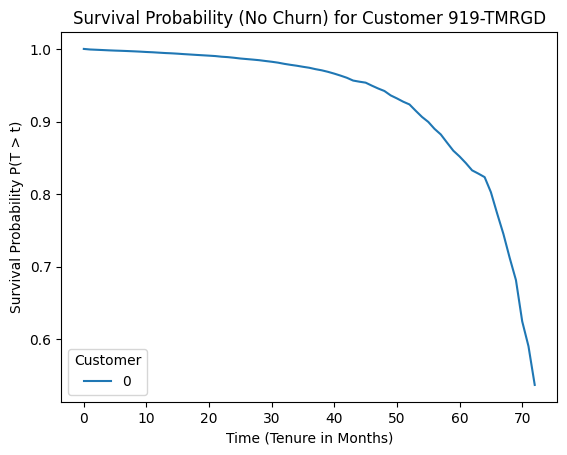

In [12]:
# Encode new data like training data
new_data_enc = pd.get_dummies(new_data)
new_data_enc = new_data_enc.reindex(columns=train_columns, fill_value=0)

# Apply scaling only to numeric columns used during training
num_cols = scaler.feature_names_in_  # available in sklearn >= 1.0
new_data_enc[num_cols] = scaler.transform(new_data_enc[num_cols])

# Predict survival function
# surv_func = cph.predict_survival_function(new_data_enc)
# surv_func.plot()


# # ... (Previous code)

# Predict survival function
surv_func = cph.predict_survival_function(new_data_enc)

# Plot the survival function and capture the plot object
ax = surv_func.plot()

# --- Add Labels and Title ---
ax.set_title(f"Survival Probability (No Churn) for Customer ")
ax.set_xlabel("Time (Tenure in Months)")
ax.set_ylabel("Survival Probability P(T > t)")

# Add a legend based on the customer ID
ax.legend(title='Customer', loc='lower left')
